# Rates using CMFGEN data

In [1]:
from copy import deepcopy
from pathlib import Path

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from tardis.io.atom_data import AtomData
from tardis.io.configuration.config_reader import Configuration
from tardis.model.base import SimulationState
from tardis.plasma.assembly.base import PlasmaSolverFactory
from tardis.plasma.equilibrium.rates import (
    AnalyticCorrectedPhotoionizationCoeffSolver,
    AnalyticPhotoionizationCoeffSolver,
    EstimatedPhotoionizationCoeffSolver,
    RadiativeRatesSolver,
    SpontaneousRecombinationCoeffSolver,
    ThermalCollisionalRateSolver,
)
from tardis.plasma.radiation_field import (
    DilutePlanckianRadiationField,
)

home = str(Path('~').expanduser())

config = Configuration.from_yaml(home+"/tardis/tardis/plasma/tests/data/plasma_base_test_config.yml")

config.supernova.time_explosion = 16.084 * u.day
config.model.structure.type = "file"
config.model.structure.filename = home+"/tardis-chvogl-configs/cmfgen_stephane_density_rebin.dat"
config.model.structure.filetype = "simple_ascii"
config.model.structure.v_inner_boundary = 10000 * u.km / u.s
config.model.structure.v_outer_boundary = 15000 * u.km / u.s

config.model.abundances.He = 0
config.model.abundances.H = 1

config.plasma.excitation = "dilute-lte"
config.plasma.ionization = "nebular"

ion_slice = (1, slice(None), slice(None), slice(None))


def get_radiative_rate_solver(radiative_transitions):
    rad_rate_solver = RadiativeRatesSolver(radiative_transitions)
    return rad_rate_solver

def get_chianti_collisional_rate_solver(atom_data, radiative_transitions,):
    col_strength_temperatures = atom_data.collision_data_temperatures
    col_strengths = atom_data.collision_data.loc[ion_slice, :]
    collisional_rate_solver = ThermalCollisionalRateSolver(atom_data.levels, radiative_transitions, col_strength_temperatures, col_strengths, 'chianti', "none")
    return collisional_rate_solver

def get_cmfgen_collisional_rate_solver(atom_data, radiative_transitions,):
    col_strength_temperatures = atom_data.yg_data.columns
    col_strengths = atom_data.yg_data.loc[ion_slice, :]
    collisional_rate_solver = ThermalCollisionalRateSolver(atom_data.levels, radiative_transitions, col_strength_temperatures, col_strengths, 'cmfgen', "regemorter")
    return collisional_rate_solver

#cmfgen_atom_data = AtomData.from_hdf(home+'/carsus/docs/kurucz_cd23_cmfgen_H_Ti.h5')
cmfgen_atom_data = AtomData.from_hdf(home+'/tardis-regression-data/atom_data/nlte_atom_data/TestNLTE_He_Ti_ctardis.h5')

cmfgen_atom_data2 = deepcopy(cmfgen_atom_data)

cmfgen_radiative_transitions = cmfgen_atom_data.lines.loc[ion_slice, :]

cmfgen_sim_state = SimulationState.from_config(config, atom_data=cmfgen_atom_data)

cmfgen_atom_data.prepare_atom_data([1], "macroatom", [], [(1, 0)])

/home/afullard/tardis/tardis/__init__.py:24: UserWarning: Astropy is already imported externally. Astropy should be imported after TARDIS.
  warnings.warn(


Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

Number of density points larger than number of shells. Assuming inner point irrelevant


# Atomic Data comparison

In [2]:
import matplotlib.pyplot as plt

In [3]:
import pandas as pd

modern_atom = pd.read_hdf('/home/afullard/tardis-regression-data/atom_data/nlte_atom_data/TestNLTE_He_Ti.h5', key="photoionization_data")
ctardis_atom = pd.read_hdf('/home/afullard/ct19/tardis/continuum/data/photoionization_data_H30_He.h5', key="photoionization_data")

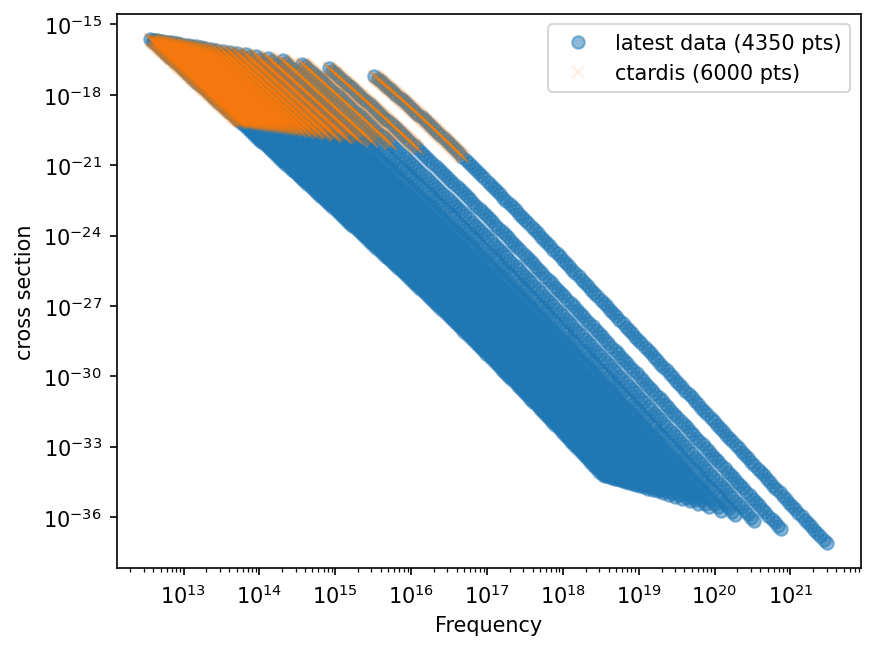

In [4]:
plt.figure(dpi=150)
plt.plot(modern_atom.loc[1,0,:]["nu"], modern_atom.loc[1,0,:]["x_sect"], "o", label="latest data (4350 pts)", alpha=0.5)
plt.plot(ctardis_atom.loc[1,0,:]["nu"], ctardis_atom.loc[1,0,:]["x_sect"], "x", label="ctardis (6000 pts)", alpha=0.1)
plt.xlabel("Frequency")
plt.ylabel("cross section")
plt.loglog()
plt.legend()

In [5]:
from tardis.plasma.electron_energy_distribution import (
    ThermalElectronEnergyDistribution,
)

cmfgen_radiative_rate_solver = get_radiative_rate_solver(cmfgen_radiative_transitions)

cmfgen_collisional_rate_solver = get_cmfgen_collisional_rate_solver(cmfgen_atom_data, cmfgen_radiative_transitions)

# need a better way to make a custom radiation field where the intensity is zero
# in specific locations as desired
rad_field = DilutePlanckianRadiationField(np.ones(24) * 10000 * u.K, #9984.96131287 * u.K, 
                                          dilution_factor=np.array(
    [ 0.18635244,  0.15938095,  0.11736085,  0.34665656,  0.32265696,
       0.30224056,  0.28436446,  0.26841929,  0.2540108 ,  0.24086562,
        0.22878441,  0.21761613,  0.20724285,  0.1975702 ,  0.18852112,
        0.18003167,  0.17204798,  0.16452412,  0.15742053,  0.15070279,
        0.14434073,  0.13830767,  0.13257993,  0.12856901]))

electron_dist = ThermalElectronEnergyDistribution(0, np.ones(24) * 10000 * u.K, #9984.96131287 * u.K, 
                                                  np.array(
    [  2.20677509e+09,   1.62501734e+09,   1.22615668e+09,
         9.43891936e+08,   7.38550008e+08,   5.87500741e+08,
         4.72954413e+08,   3.82162389e+08,   3.08702916e+08,
         2.49243299e+08,   2.01203976e+08,   1.62424770e+08,
         1.31111090e+08,   1.05846840e+08,   8.54394007e+07,
         6.89750790e+07,   5.56796014e+07,   4.49524605e+07,
         3.62858202e+07,   2.92940480e+07,   2.36477502e+07,
         1.90900977e+07,   1.54111736e+07,   1.24410890e+07] )* u.cm**-3)

temperature = electron_dist.temperature

In [6]:
rate_solvers = [(cmfgen_radiative_rate_solver, "radiative"), (cmfgen_collisional_rate_solver, "electron")]

lte_rate_solvers = [(cmfgen_collisional_rate_solver, "electron")]

In [7]:
rad_rates = cmfgen_radiative_rate_solver.solve(rad_field)

In [8]:
col_rates = cmfgen_collisional_rate_solver.solve(electron_dist.temperature)

# Comparison to cTARDIS rate calculations

Previous rates were calculated using 

cTARDIS

In [9]:
photoionization_coeff_ctardis = pd.read_csv("/home/afullard/tardis-chvogl-configs/rate_coefficients.csv", index_col=[0, 1, 2], skiprows=16)
uncorrected_photoionization_coeff_ctardis = pd.read_csv("/home/afullard/tardis-chvogl-configs/uncorrected_photoion_coeff.csv", index_col=[0, 1, 2])

In [10]:
spontaneous_recombination_coeff_solver = SpontaneousRecombinationCoeffSolver(cmfgen_atom_data.photoionization_data,)
photoionization_coeff_solver = AnalyticPhotoionizationCoeffSolver(cmfgen_atom_data.photoionization_data,)

spontaneous_recombination_rate = spontaneous_recombination_coeff_solver.solve(temperature)
photoionization_rate_coeff, stimulated_recombination_rate_coeff = photoionization_coeff_solver.solve(rad_field, temperature)

Current differences:
- Atomic data for ctardis is 6000 rows and covers a smaller frequency range (but seems to have the same slope)
- ~~Integrated (summed) J_nu (mean intensity for the dilute radiation field) is different by a factor of ~2. Raw values for individual frequencies seem similar~~
- Correction factor is very different (need to use correct number densities)
- ~~Prefactor alpha_k(nu) seems different but could be due to data range~~


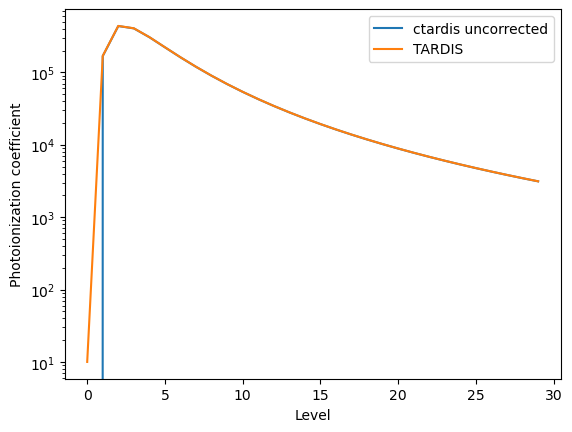

In [11]:
#plt.plot(photoionization_coeff_ctardis["0"].to_numpy(), label="ctardis")
plt.plot(uncorrected_photoionization_coeff_ctardis["0"].to_numpy(), label="ctardis uncorrected")
plt.plot(photoionization_rate_coeff[0].to_numpy(), label="TARDIS")
plt.semilogy()
plt.xlabel("Level")
plt.ylabel("Photoionization coefficient")
plt.legend()

(0.0, 5.0)

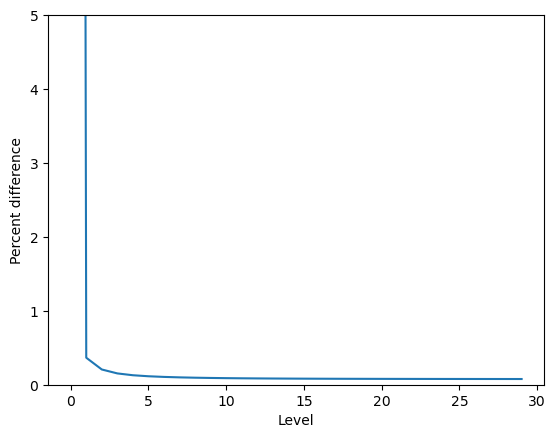

In [12]:
plt.plot((photoionization_rate_coeff[0].to_numpy() - uncorrected_photoionization_coeff_ctardis["0"].to_numpy()) / (uncorrected_photoionization_coeff_ctardis["0"].to_numpy() + photoionization_rate_coeff[0].to_numpy()) * 100)
plt.xlabel("Level")
plt.ylabel("Percent difference")
plt.ylim(0, 5)

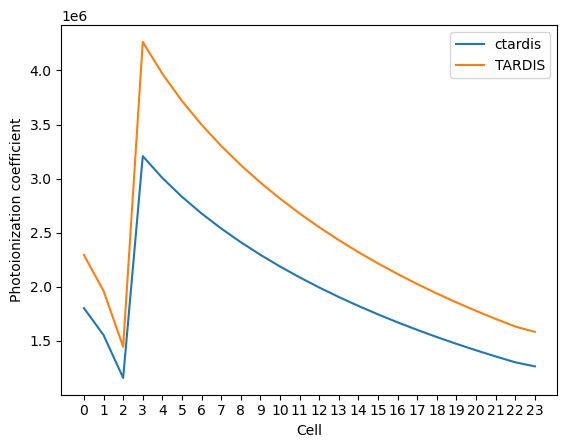

In [13]:
df1 = photoionization_coeff_ctardis.groupby(
            level=("atomic_number", "ion_number")
        ).sum()
df2 = photoionization_rate_coeff.groupby(
            level=("atomic_number", "ion_number")
        ).sum()

plt.plot(df1.T, label="ctardis")
plt.plot(df2.T, label="TARDIS")
plt.xlabel("Cell")
plt.ylabel("Photoionization coefficient")
plt.legend()

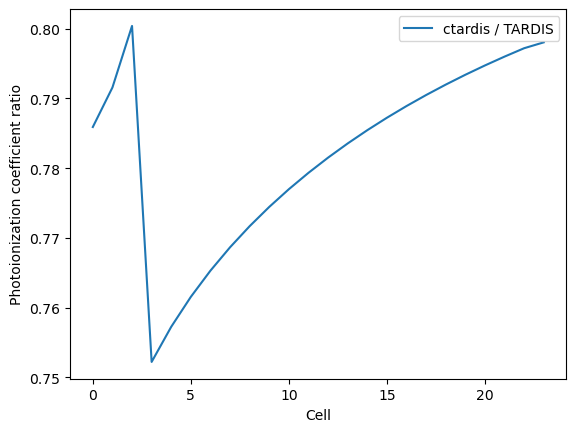

In [14]:
plt.plot(df1.T.to_numpy() / df2.T.to_numpy(), label="ctardis / TARDIS")
plt.xlabel("Cell")
plt.ylabel("Photoionization coefficient ratio")
plt.legend()

In [15]:
ctardis_path = "/home/afullard/tardis-chvogl-configs/"

ion_number_density_ctardis = pd.read_csv(ctardis_path+"ion_density.csv", index_col=[0, 1])
lte_ion_number_density_ctardis = pd.read_csv(ctardis_path+"lte_ion_number_density.csv", index_col=[0, 1])

level_number_density_ctardis = pd.read_csv(ctardis_path+"level_pop.csv", index_col=[0])
lte_level_number_density_ctardis = pd.read_csv(ctardis_path+"lte_level_pop.csv", index_col=[0])

correction_factor_ctardis = pd.read_csv(ctardis_path+"correction_factor_ctardis.csv", index_col=[0])

recomb_coeff_ctardis = pd.read_csv(ctardis_path+"recombination_coeff.csv", index_col=[0, 1, 2])

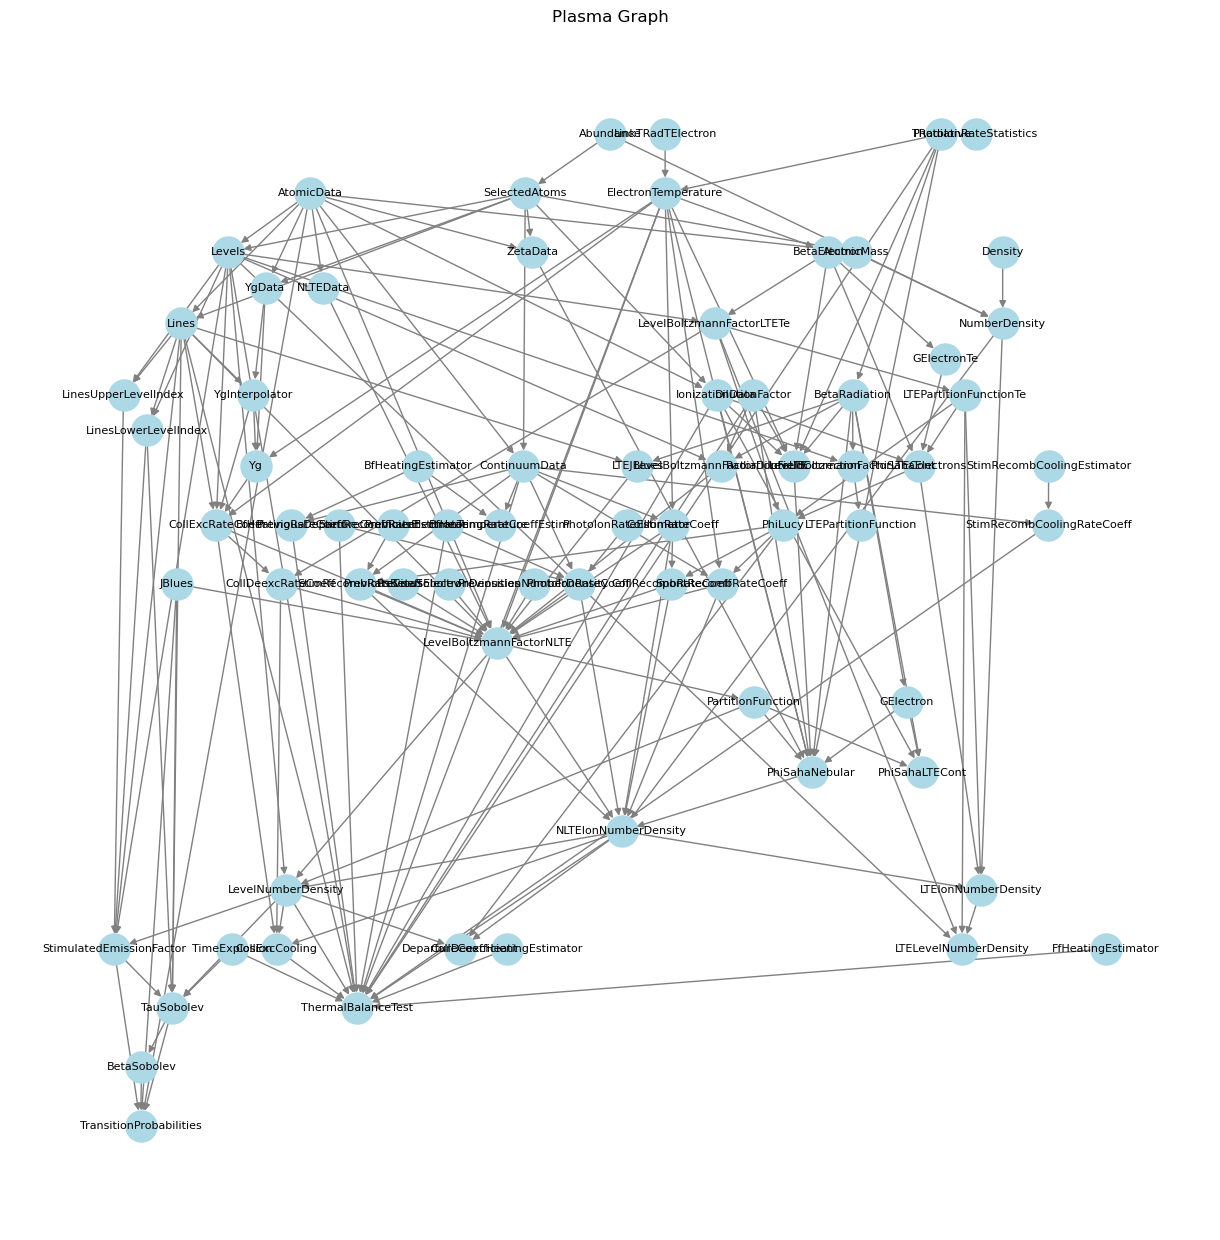

In [16]:
import networkx as nx

G = nx.read_graphml(ctardis_path+"plasma_graph.gml")
pos = nx.nx_agraph.graphviz_layout(G, prog='dot')

# Draw the graph
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=8, font_color='black', edge_color='gray')
plt.title('Plasma Graph')
plt.show()

# Build custom property collection

In [17]:
plasma_solver_factory = PlasmaSolverFactory(cmfgen_atom_data2, config)
plasma_solver_factory.prepare_factory([1],"tardis.plasma.properties.property_collections" )
cmfgen_plasma = plasma_solver_factory.assemble(cmfgen_sim_state.elemental_number_density, rad_field, cmfgen_sim_state.time_explosion, electron_dist.number_density, link_t_rad_t_electron=1)

Zeta_data missing - replaced with 1s. Missing ions: []
Zeta_data missing - replaced with 1s. Missing ions: []


# Custom Ion LTE

Differences: Phi at electron temp is VERY CLOSE, LTE partition function is SAME, basic elemental number density is VERY CLOSE, electron densities are VERY CLOSE

LTE and "non-LTE" ion pops in TARDIS plasma are identical right now!

In [18]:
from tardis.plasma.properties.ion_population import IonNumberDensity

class LTEIonNumberDensity(IonNumberDensity):
    outputs = ('lte_ion_number_density', )
    latex_name = ('N_{i,j}^*',)

    def calculate(self, phi_Te, lte_partition_function_Te, number_density, electron_densities, block_ids, ion_threshold):
        return self.calculate_with_n_electron(
            phi_Te, lte_partition_function_Te, number_density, electron_densities, block_ids, ion_threshold)

# Custom level LTE

Check input values for calculations use LTE or "NLTE" quantities as appropriate

Check precisely what step values are sourced from- are these first iteration or not?


In [19]:
from tardis.plasma.properties.level_population import (
    LevelNumberDensity,
)

class LTELevelNumberDensity(LevelNumberDensity):
    outputs = ('lte_level_number_density',)
    latex_name = ('N_{i,j,k}^*',)

    def _calculate_dilute_lte(self, lte_level_boltzmann_factor_Te, lte_ion_number_density,
                              levels, lte_partition_function_Te):
        return super(LTELevelNumberDensity, self)._calculate_dilute_lte(
            lte_level_boltzmann_factor_Te, lte_ion_number_density, levels, lte_partition_function_Te)

In [20]:
lte_ion_number_density = LTEIonNumberDensity(cmfgen_plasma,
                                             electron_densities=cmfgen_plasma.electron_densities
                                             ).calculate(
                                                 cmfgen_plasma.thermal_phi_lte,
                                                 cmfgen_plasma.thermal_lte_partition_function,
                                                 cmfgen_sim_state.elemental_number_density,
                                                 cmfgen_plasma.electron_densities,
                                                 None, 1e-20)[0]

In [21]:
lte_level_number_density = LTELevelNumberDensity(cmfgen_plasma
                                                 ).calculate(
                                                     cmfgen_plasma.thermal_lte_level_boltzmann_factor,
                                                     lte_ion_number_density,
                                                     cmfgen_plasma.levels,
                                                     cmfgen_plasma.thermal_lte_partition_function)

### NB- not really a "Saha Factor", this is $\Phi_{i,\kappa}$ as defined in Lucy 03 Eq 14

In [22]:
saha_factor = lte_level_number_density.loc[lte_level_number_density.index.get_level_values('ion_number') < 1] / (
            lte_ion_number_density.loc[lte_ion_number_density.index.get_level_values('ion_number') >= 1].values
            * electron_dist.number_density.value
        )

<Axes: xlabel='atomic_number,ion_number,level_number'>

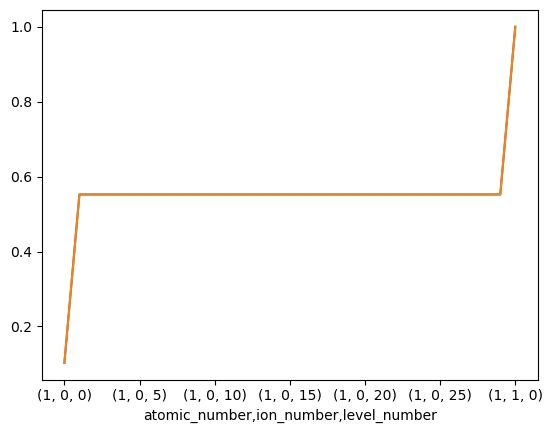

In [23]:
(lte_level_number_density_ctardis["0"] / level_number_density_ctardis["0"]).plot()
(lte_level_number_density[0] / cmfgen_plasma.level_number_density[0]).plot()

<Axes: xlabel='atomic_number,ion_number'>

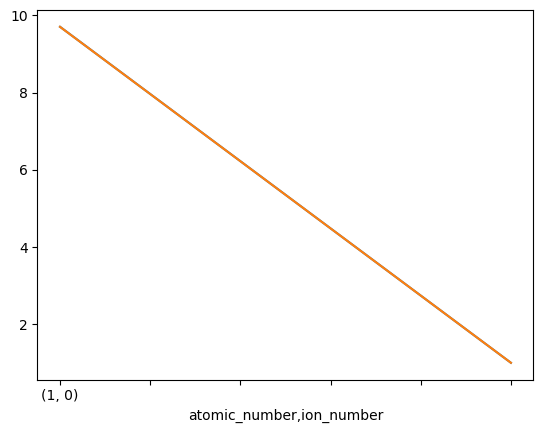

In [24]:
(ion_number_density_ctardis["0"] / lte_ion_number_density_ctardis["0"]).plot()
(cmfgen_plasma.ion_number_density[0] / lte_ion_number_density[0]).plot()

<Axes: xlabel='atomic_number,ion_number,level_number'>

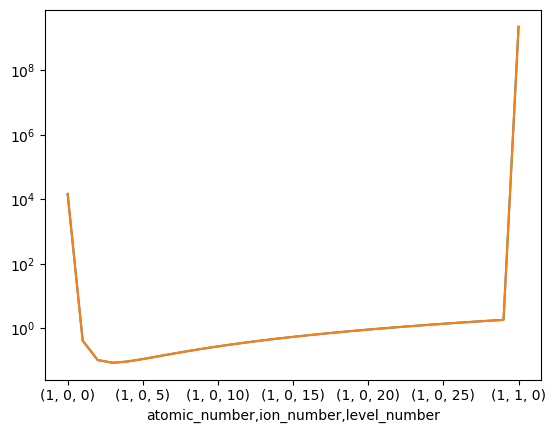

In [25]:
lte_level_number_density_ctardis["0"].plot(logy=True)
lte_level_number_density[0].plot(logy=True)

<Axes: xlabel='atomic_number,ion_number'>

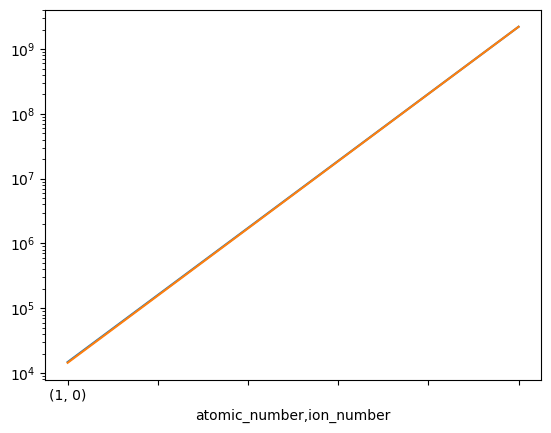

In [26]:
lte_ion_number_density_ctardis["0"].plot(logy=True)
lte_ion_number_density[0].plot(logy=True)

<Axes: xlabel='atomic_number,ion_number'>

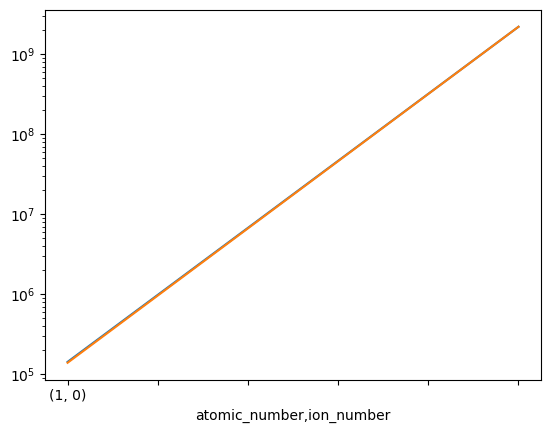

In [27]:
ion_number_density_ctardis["0"].plot(logy=True)
cmfgen_plasma.ion_number_density[0].plot(logy=True)

In [28]:
photoion_boltzmann_factor = photoionization_coeff_solver.calculate_photoionization_boltzmann_factor(electron_dist.temperature)

photoion_boltzmann_factor = pd.DataFrame(photoion_boltzmann_factor, index=photoionization_coeff_solver.common_prefactor.index)

In [29]:
ctardis_ratio = pd.read_csv(ctardis_path+"lte_nonlte_ratio.csv", index_col=[0])
tardis_ratio = (cmfgen_plasma.ion_number_density / lte_ion_number_density) * (lte_level_number_density / cmfgen_plasma.level_number_density)

All parts of the correction factor seem to match- but it returns nonsensical negative results

In [30]:
correction_factor_tardis = 1 - (cmfgen_plasma.ion_number_density.loc[1,1] / lte_ion_number_density.loc[1,1]) * (lte_level_number_density / cmfgen_plasma.level_number_density) * photoion_boltzmann_factor

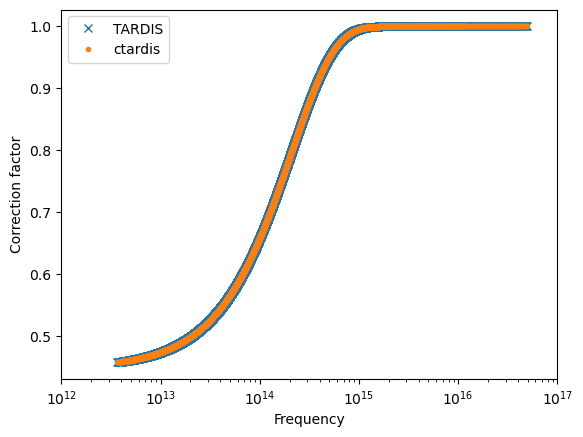

In [31]:
plt.plot(ctardis_atom.loc[1,0,:]["nu"], correction_factor_tardis[0][:6000], "x", label="TARDIS")
plt.plot(ctardis_atom.loc[1,0,:]["nu"], correction_factor_ctardis["0"], ".", label="ctardis")
plt.xlim(1e12, 1e17)
plt.semilogx()
plt.xlabel("Frequency")
plt.ylabel("Correction factor")
plt.legend()

In [32]:
charge_conservation_row = []
for atomic_number in [1]:
    charge_conservation_row.append(np.arange(0, atomic_number + 1))
charge_conservation_row = np.hstack([*charge_conservation_row, -1])

In [33]:
charge_conservation_row

array([ 0,  1, -1])

In [34]:
from tardis.plasma.equilibrium.rates import AnalyticPhotoionizationRateSolver

photoionization_rate_solver = AnalyticPhotoionizationRateSolver(cmfgen_atom_data.photoionization_data)
corr_photoion_coeff_solver = AnalyticCorrectedPhotoionizationCoeffSolver(cmfgen_atom_data.photoionization_data)

In [35]:
corr_photoion_coeff = corr_photoion_coeff_solver.solve(
    rad_field,
    electron_dist.temperature,
    lte_level_number_density.loc[lte_level_number_density.index.get_level_values('ion_number') < 1],
    cmfgen_plasma.level_number_density.loc[cmfgen_plasma.level_number_density.index.get_level_values('ion_number') < 1],
    lte_ion_number_density.loc[lte_ion_number_density.index.get_level_values('ion_number') >= 1],
    cmfgen_plasma.ion_number_density.loc[cmfgen_plasma.ion_number_density.index.get_level_values('ion_number') >= 1],
    )

In [36]:
estimated_photoion_coeff_ctardis = pd.read_csv(ctardis_path+"estimated_photoion_coeff.csv", index_col=[0, 1, 2])

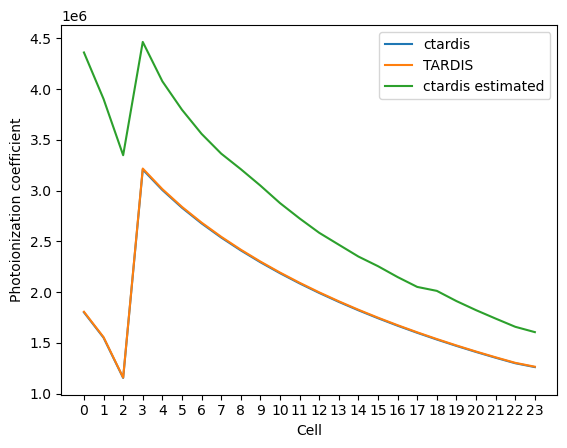

In [37]:
df1 = photoionization_coeff_ctardis.groupby(
            level=("atomic_number", "ion_number")
        ).sum()
df2 = corr_photoion_coeff.groupby(
            level=("atomic_number", "ion_number")
        ).sum()
df3 = estimated_photoion_coeff_ctardis.groupby(
            level=("atomic_number", "ion_number")
        ).sum()


plt.plot(df1.T, label="ctardis")
plt.plot(df2.T, label="TARDIS")
plt.plot(df3.T, label="ctardis estimated")
plt.xlabel("Cell")
plt.ylabel("Photoionization coefficient")
plt.legend()

/tmp/ipykernel_172548/3826348831.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


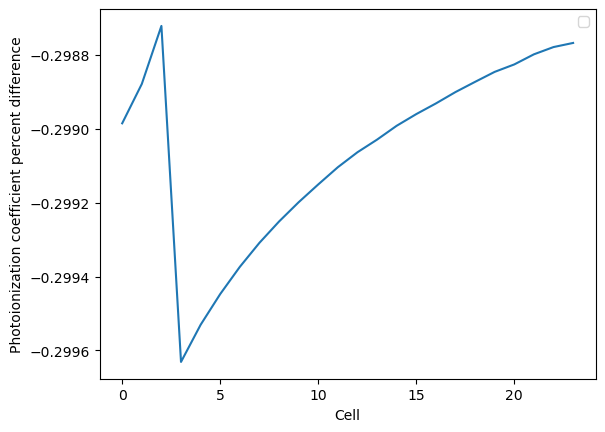

In [38]:
plt.plot((df1.T.values - df2.T.values)/df2.T.values * 100)
#plt.plot(df3.T, label="TARDIS")
plt.xlabel("Cell")
plt.ylabel("Photoionization coefficient percent difference")
plt.legend()

In [39]:
from tardis.plasma.equilibrium.rates import SpontaneousRecombinationCoeffSolver

recomb_rate_solver = SpontaneousRecombinationCoeffSolver(cmfgen_atom_data.photoionization_data)

recomb_coeff = recomb_rate_solver.solve(electron_dist.temperature)

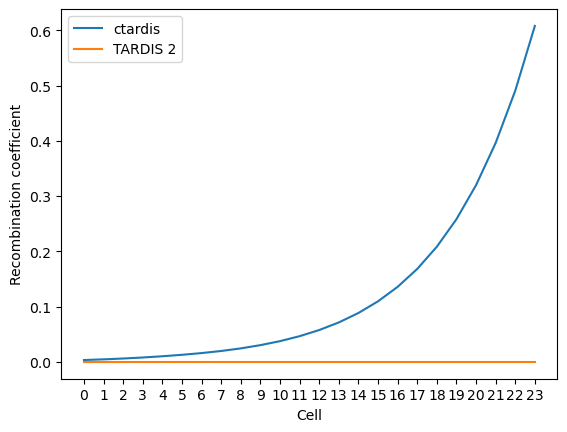

In [40]:
df1 = recomb_coeff_ctardis.groupby(
            level=("atomic_number", "ion_number")
        ).sum()
df2 = recomb_coeff.groupby(
            level=("atomic_number", "ion_number")
        ).sum()

df3 = (recomb_coeff * saha_factor).groupby(
            level=("atomic_number", "ion_number")
        ).sum()

plt.plot(df1.T, label="ctardis")
#plt.plot(df2.T, label="TARDIS")
plt.plot(df3.T, label="TARDIS 2")
plt.xlabel("Cell")
plt.ylabel("Recombination coefficient")
plt.legend()

### Corrected photoionization rates

DO NOT match estimated rates from ctardis at all

<Axes: xlabel='atomic_number,ion_number,level_number'>

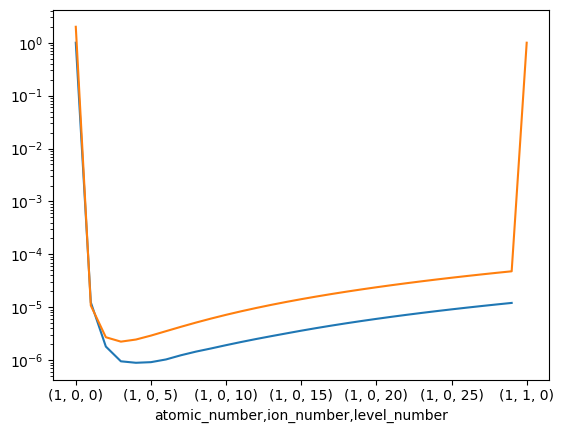

In [41]:
level_pop_fraction_ctardis = pd.read_csv(ctardis_path+"level_pop_fractions.csv", index_col=[0, 1, 2])
level_pop_fraction_ctardis.columns = level_pop_fraction_ctardis.columns.astype(int)

level_pop_fraction_ctardis[0].T.plot(logy=True)
(cmfgen_plasma.level_boltzmann_factor / cmfgen_plasma.partition_function.loc[(1,1)])[0].T.plot(logy=True)
#(cmfgen_plasma.thermal_lte_level_boltzmann_factor / cmfgen_plasma.partition_function.loc[(1,1)])[0].T.plot(logy=True)
#(cmfgen_plasma.general_level_boltzmann_factor / cmfgen_plasma.partition_function.loc[(1,1)])[0].T.plot(logy=True)

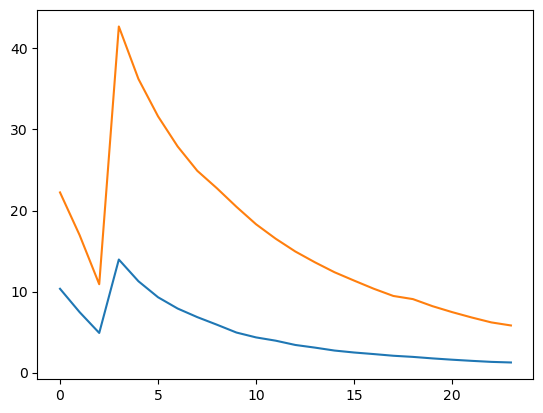

In [42]:
plt.plot((estimated_photoion_coeff_ctardis.values * level_pop_fraction_ctardis.values).sum(axis=0).T)
plt.plot((estimated_photoion_coeff_ctardis.values * cmfgen_plasma.level_boltzmann_factor.loc[1,0].values).sum(axis=0).T)

In [43]:
boltzmann_factor_ctardis = pd.read_csv(ctardis_path+"level_boltzmann_factor_ctardis.csv", index_col=[0, 1, 2])
boltzmann_factor_ctardis.columns = boltzmann_factor_ctardis.columns.astype(int)

photoion_rates, recomb_rates = photoionization_rate_solver.solve(rad_field, electron_dist, lte_level_number_density.loc[lte_level_number_density.index.get_level_values('ion_number') < 1], 
    cmfgen_plasma.level_number_density.loc[cmfgen_plasma.level_number_density.index.get_level_values('ion_number') < 1],
    lte_ion_number_density.loc[lte_ion_number_density.index.get_level_values('ion_number') >= 1],
    cmfgen_plasma.ion_number_density.loc[cmfgen_plasma.ion_number_density.index.get_level_values('ion_number') >= 1],
    1.0,
    boltzmann_factor_ctardis,
   )

<Axes: >

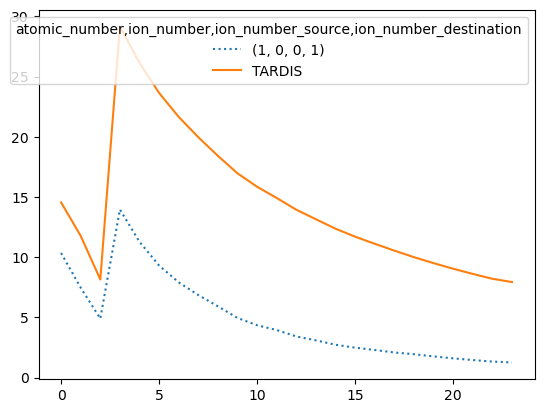

In [44]:
photoion_rates_ctardis = pd.read_csv(ctardis_path+"photoion_tot.csv", index_col=[0, 1])
photoion_rates_ctardis.columns = photoion_rates_ctardis.columns.astype(int)

photoion_rates_ctardis.reset_index(inplace=True)

photoion_rates_ctardis["ion_number_destination"] = photoion_rates_ctardis["ion_number"] + 1
photoion_rates_ctardis["ion_number_source"] = photoion_rates_ctardis["ion_number"]
photoion_rates_ctardis.set_index(['atomic_number', 'ion_number', 'ion_number_source', 'ion_number_destination'], inplace=True)

photoion_rates_ctardis = photoion_rates_ctardis.iloc[:-1]

photoion_rates_ctardis.T.plot(label="ctardis", ls = ":")
photoion_rates.sum().plot(label="TARDIS",legend=True)

<Axes: >

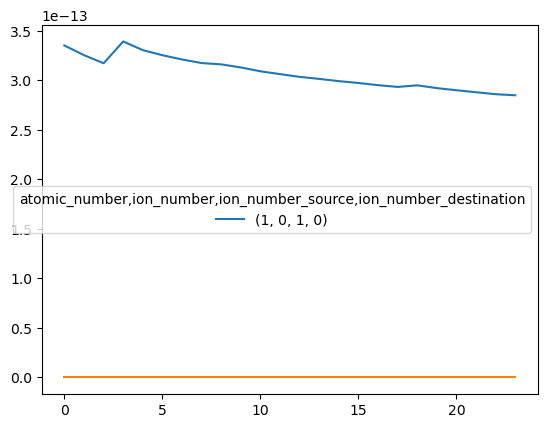

In [45]:
recomb_rates_ctardis = pd.read_csv(ctardis_path+"recomb_tot.csv", index_col=[0, 1])
recomb_rates_ctardis.columns = recomb_rates_ctardis.columns.astype(int)

recomb_rates_ctardis.reset_index(inplace=True)

recomb_rates_ctardis["ion_number_destination"] = recomb_rates_ctardis["ion_number"]
recomb_rates_ctardis["ion_number_source"] = recomb_rates_ctardis["ion_number"] + 1

recomb_rates_ctardis.set_index(['atomic_number', 'ion_number', 'ion_number_source', 'ion_number_destination'], inplace=True)

recomb_rates_ctardis = recomb_rates_ctardis.iloc[:-1]

recomb_rates_ctardis.T.plot()
(recomb_rates.sum() / electron_dist.number_density).plot()

# Collisional rates

Match both pre- and post- estimator rates from ctardis

In [46]:
from tardis.plasma.equilibrium.rate_matrix import IonRateMatrix
from tardis.plasma.equilibrium.rates import CollisionalIonizationRateSolver

collisional_rate_solver = CollisionalIonizationRateSolver(cmfgen_atom_data.photoionization_data)

In [47]:
coll_ion_rates, coll_recomb_rates = collisional_rate_solver.solve(
    electron_dist, 
    saha_factor, 
    1.0,
    boltzmann_factor_ctardis,)

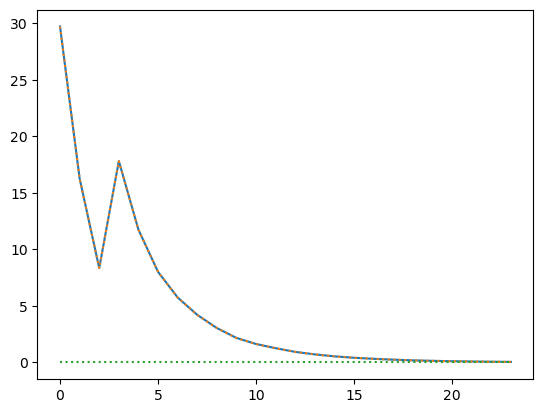

In [48]:
tardis_coll_ion = coll_ion_rates.groupby(level=("atomic_number", "ion_number")).sum().T
coll_ion_coeff_ctardis = pd.read_csv(ctardis_path+"coll_ion_total.csv", index_col=[0, 1])
coll_ion_coeff_ctardis.columns = coll_ion_coeff_ctardis.columns.astype(int)

coll_ion_coeff_ctardis.reset_index(inplace=True)

coll_ion_coeff_ctardis["ion_number_source"] = coll_ion_coeff_ctardis["ion_number"]
coll_ion_coeff_ctardis["ion_number_destination"] = coll_ion_coeff_ctardis["ion_number"] + 1

coll_ion_coeff_ctardis.set_index(['atomic_number', 'ion_number', 'ion_number_source', 'ion_number_destination'], inplace=True)


ctardis_coll_ion = (coll_ion_coeff_ctardis.groupby(level=("atomic_number", "ion_number")).sum() * electron_dist.number_density).T

plt.plot(tardis_coll_ion, label="TARDIS")
plt.plot(ctardis_coll_ion, label="ctardis", ls=':')

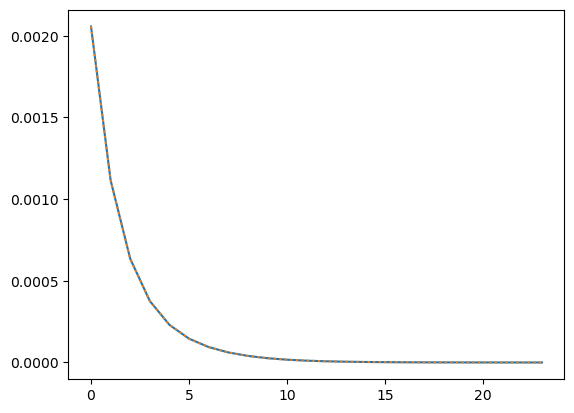

In [49]:
tardis_coll_recomb = coll_recomb_rates.groupby(level=("atomic_number", "ion_number")).sum().T
coll_recomb_coeff_ctardis = pd.read_csv(ctardis_path+"coll_recomb_coeff_ctardis.csv", index_col=[0, 1, 2])
coll_recomb_coeff_ctardis = coll_recomb_coeff_ctardis.groupby(level=("atomic_number", "ion_number")).sum() * electron_dist.number_density **2
coll_recomb_coeff_ctardis.columns = coll_recomb_coeff_ctardis.columns.astype(int)

coll_recomb_coeff_ctardis.reset_index(inplace=True)

coll_recomb_coeff_ctardis["ion_number_source"] = coll_recomb_coeff_ctardis["ion_number"] + 1
coll_recomb_coeff_ctardis["ion_number_destination"] = coll_recomb_coeff_ctardis["ion_number"]

coll_recomb_coeff_ctardis.set_index(['atomic_number', 'ion_number', 'ion_number_source', 'ion_number_destination'], inplace=True)


ctardis_coll_recomb = coll_recomb_coeff_ctardis.T

plt.plot(tardis_coll_recomb, label="TARDIS")
plt.plot(ctardis_coll_recomb, label="ctardis",  ls=':')

In [50]:
coll_recomb_coeff_ctardis

,,,,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
atomic_number,ion_number,ion_number_source,ion_number_destination,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0.002057,0.001115,0.000635,0.000376,0.00023,0.000146,0.000094,0.000062,0.00004,0.000026,...,0.000003,0.000002,0.000001,8.534125e-07,5.560655e-07,3.624189e-07,2.361738e-07,1.539105e-07,1.003052e-07,6.536855e-08


In [51]:
class dummyphotoionratesolver:
    def __init__(self, ctardis_photoion_rates, ctardis_recomb_rates):
        self.photoion_rates = ctardis_photoion_rates
        self.recomb_rates = ctardis_recomb_rates
    def solve(self, rad_field, electron_dist, level_population, lte_level_population, lte_ion_number_density=None, ion_number_density=None, x=None, y=None):
        return self.photoion_rates, self.recomb_rates

dummy_rate_solver = dummyphotoionratesolver(photoion_rates_ctardis, recomb_rates_ctardis * electron_dist.number_density)
dummy_col_rate_solver = dummyphotoionratesolver(coll_ion_rates, coll_recomb_coeff_ctardis)

ion_rate_matrix_solver = IonRateMatrix(dummy_rate_solver, collisional_rate_solver)

# Ion rate matrix

In [52]:
ion_rate_matrix = ion_rate_matrix_solver.solve(rad_field, electron_dist, lte_level_number_density.loc[lte_level_number_density.index.get_level_values('ion_number') < 1], 
    cmfgen_plasma.level_number_density.loc[cmfgen_plasma.level_number_density.index.get_level_values('ion_number') < 1],
    lte_ion_number_density.loc[lte_ion_number_density.index.get_level_values('ion_number') >= 1],
    cmfgen_plasma.ion_number_density.loc[cmfgen_plasma.ion_number_density.index.get_level_values('ion_number') >= 1],
    1.0,
    boltzmann_factor_ctardis,
    charge_conservation=True)

In [53]:
ion_rate_matrix[0].values

array([array([[ 0.00000000e+00,  1.00000000e+00, -1.00000000e+00],
              [-4.00623411e+01,  2.79598601e-03,  0.00000000e+00],
              [ 1.00000000e+00,  1.00000000e+00,  0.00000000e+00]])],
      dtype=object)

# Charge exchange rates mean that we cannot normalize the population vector

Look up ground state number conservation- replaced with highes or lowest number density. Mihalas. Check original stellar atmosphere book instead of newer for NLTE

In [54]:
from tardis.plasma.equilibrium.ion_populations import IonPopulationSolver

solver = IonPopulationSolver(ion_rate_matrix_solver)

ion_pops, electron_densities = solver.solve(
    rad_field,
    electron_dist,
    cmfgen_sim_state.elemental_number_density,
    lte_level_number_density,
    cmfgen_plasma.level_number_density,
    lte_ion_number_density,
    cmfgen_plasma.ion_number_density,
    1.0,
    boltzmann_factor_ctardis,
    charge_conservation=False)

Ion population solver converged after 4 iterations.


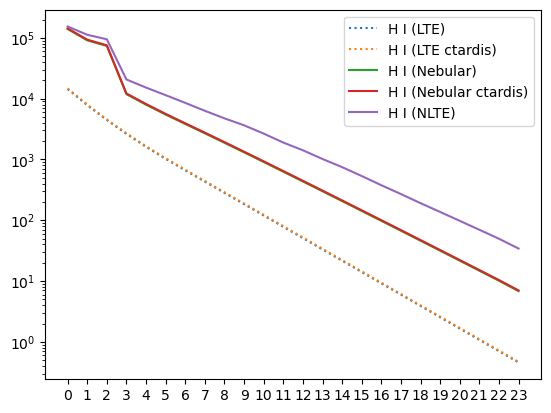

In [55]:
plt.plot(lte_ion_number_density.T.iloc[:, 0], label='H I (LTE)', ls=":")
plt.plot(lte_ion_number_density_ctardis.T.iloc[:, 0], label='H I (LTE ctardis)', ls=":")
plt.plot(cmfgen_plasma.ion_number_density.T.iloc[:, 0], label='H I (Nebular)')
plt.plot(ion_number_density_ctardis.T.iloc[:, 0], label='H I (Nebular ctardis)')
plt.plot(ion_pops.T.iloc[:, 0], label='H I (NLTE)')
plt.semilogy()
plt.legend()

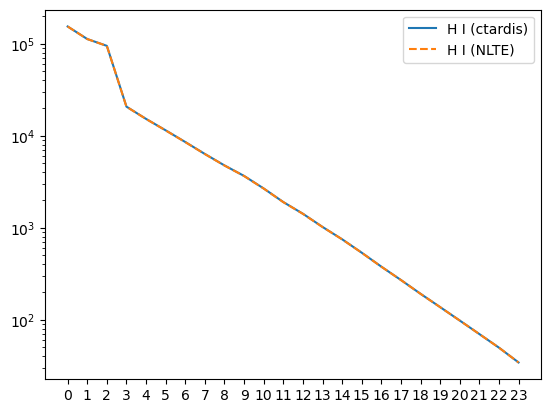

In [ ]:
ion_number_density_ctardis_final = pd.read_csv(ctardis_path+"ion_number_densities_ctardis_result.csv", index_col=[0, 1])

plt.plot(ion_number_density_ctardis_final.T.iloc[:, 0], label='H I (ctardis)')
plt.plot(ion_pops.T.iloc[:, 0], label='H I (NLTE)', ls="--")
plt.semilogy()
plt.legend()

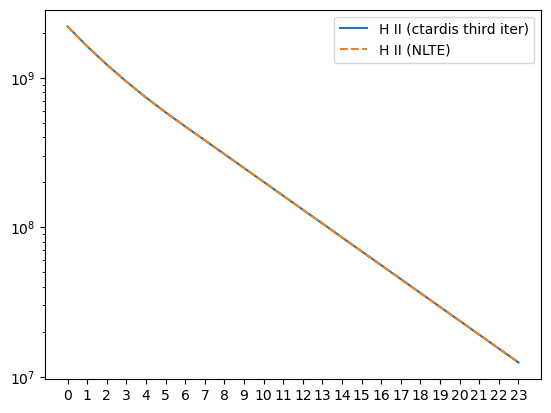

In [72]:
plt.plot(ion_number_density_ctardis_final.T.iloc[:, 1], label='H II (ctardis third iter)')
plt.plot(ion_pops.T.iloc[:, 1], label='H II (NLTE)', ls="--")
plt.semilogy()
plt.legend()

Text(0.5, 1.0, 'Percentage Residuals of H I NLTE vs H I CTARDIS')

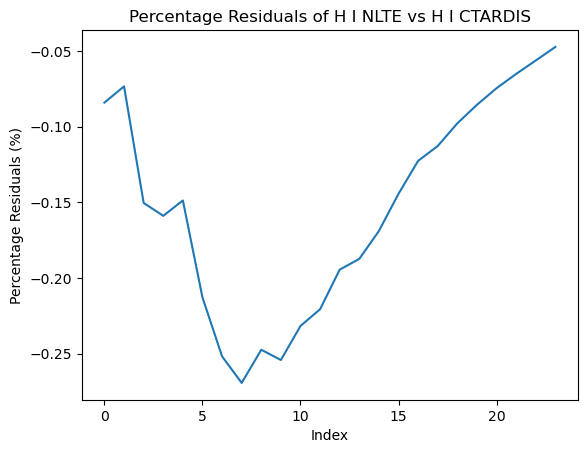

In [73]:
residuals = ((ion_pops.T.iloc[:, 0].values - ion_number_density_ctardis_final.T.iloc[:, 0].values) / ion_number_density_ctardis_final.T.iloc[:, 0].values) * 100
plt.plot(residuals, label='Percentage Residuals (H I NLTE - H I CTARDIS)')
plt.xlabel('Index')
plt.ylabel('Percentage Residuals (%)')
plt.title('Percentage Residuals of H I NLTE vs H I CTARDIS')

Text(0.5, 1.0, 'Percentage Residuals of H II NLTE vs H II CTARDIS')

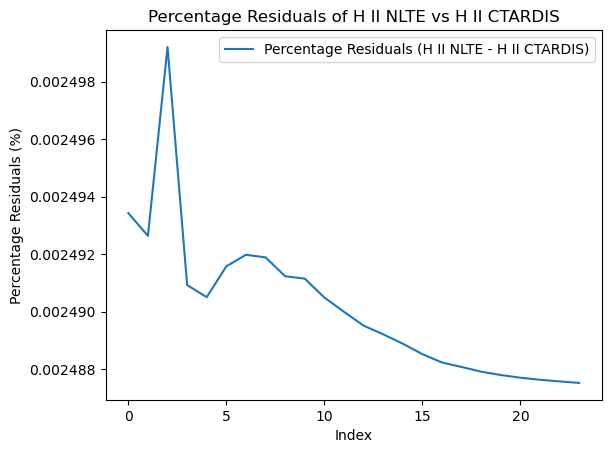

In [74]:
residuals_hii = ((ion_pops.T.iloc[:, 1].values - ion_number_density_ctardis_final.T.iloc[:, 1].values) / ion_number_density_ctardis_final.T.iloc[:, 1].values) * 100
plt.plot(residuals_hii, label='Percentage Residuals (H II NLTE - H II CTARDIS)')
plt.xlabel('Index')
plt.ylabel('Percentage Residuals (%)')
plt.legend()
plt.title('Percentage Residuals of H II NLTE vs H II CTARDIS')

Text(0.5, 1.0, 'Percentage Residuals of e NLTE vs e ctardis')

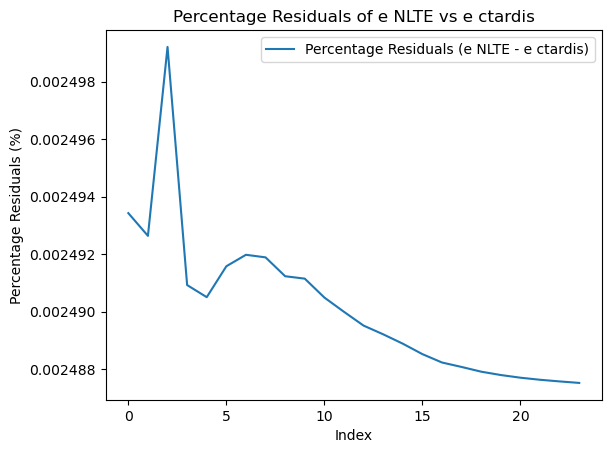

In [94]:
electron_densities_ctardis = pd.read_csv(ctardis_path+"electron_densities_ctardis_result.csv", index_col=0, header=None)

residuals_electron= ((electron_densities - electron_densities_ctardis[1]) / electron_densities_ctardis[1]) * 100
plt.plot(residuals_electron, label='Percentage Residuals (e NLTE - e ctardis)')
plt.xlabel('Index')
plt.ylabel('Percentage Residuals (%)')
plt.legend()
plt.title('Percentage Residuals of e NLTE vs e ctardis')

In [ ]:
from tardis.plasma.equilibrium.level_populations import LevelPopulationSolver
from tardis.plasma.equilibrium.rate_matrix import RateMatrix

rate_matrix_solver = RateMatrix(rate_solvers, cmfgen_atom_data.levels)

rate_matrix = rate_matrix_solver.solve(rad_field, electron_dist)

lte_rate_matrix = RateMatrix(lte_rate_solvers, cmfgen_atom_data.levels).solve(rad_field, electron_dist)

In [ ]:
solver = LevelPopulationSolver(rate_matrix, cmfgen_atom_data.levels)

level_pops = solver.solve()

lte_level_pops = LevelPopulationSolver(lte_rate_matrix, cmfgen_atom_data.levels).solve()

In [ ]:
plt.scatter(cmfgen_atom_data.levels.loc[1,0].energy * u.erg.to('eV'), level_pops.loc[1,0,:][0], marker='x', label='TARDIS')
plt.scatter(cmfgen_atom_data.levels.loc[1,0].energy * u.erg.to('eV'), level_number_density_ctardis["0"][:30], marker='x', label='cTARDIS')
#plt.scatter(cmfgen_atom_data.levels.loc[1,0].energy * u.erg.to('eV'), lte_level_pops.loc[1,0,:][0], marker='x', label='TARDIS col only')
plt.xlabel("Energy (eV)")
plt.ylabel("Population")
plt.semilogy()
plt.legend()